### Load the Data

In [1]:
import pandas as pd

# Load benign and malicious URL data
benign_df = pd.read_excel("benign_urls.xlsx")
malicious_df = pd.read_excel("malicious_urls.xlsx")

# Assign labels
benign_df["label"] = 1  # Safe
malicious_df["label"] = 0  # Malicious

# Combine both datasets
df = pd.concat([benign_df, malicious_df], ignore_index=True)

# Display first few rows
print("Dataset Loaded Successfully!")
print("Total URLs:", len(df))
print("Sample Data:")
df.head()


Dataset Loaded Successfully!
Total URLs: 37795
Sample Data:


,URL,label
0,google.com,1
1,microsoft.com,1
2,mail.ru,1
3,facebook.com,1
4,dzen.ru,1


### Feature Extraction

In [2]:
import nltk
from nltk.corpus import words
import re

# ✅ Download word list (only need to run once)
nltk.download('words')

# ✅ Load dictionary of English words
english_words = set(words.words())

# ✅ Define suspicious keyword lists
phishing_keywords = [
    'login', 'secure', 'verify', 'update', 'account', 'banking', 'password', 
    'signin', 'confirm', 'validate', 'reset', 'support', 'auth', 'authentication'
]
suspicious_domains = [
    'paypal', 'ebay', 'amazon', 'bankofamerica', 'facebook', 'google', 'apple', 
    'microsoft', 'gov', 'crypto', 'wallet', 'bitcoin', 'investment'
]
obfuscation_words = ['free', 'bonus', 'offer', 'win', 'prize', 'cheap', 'discount', 'gift']

# ✅ Feature Extraction Function
def extract_features(url):
    features = {}
    
    # Basic length features
    features['url_length'] = len(url)
    features['domain_length'] = len(re.findall(r"https?://([^/]+)", url)[0]) if re.findall(r"https?://([^/]+)", url) else 0
    features['path_length'] = len(url.split('/')) - 3  # Excluding protocol and domain

    # Special character counts
    features['num_dots'] = url.count('.')
    features['num_slashes'] = url.count('/')
    features['num_double_slash'] = url.count('//') - 1
    features['num_dashes'] = url.count('-')
    features['num_at'] = url.count('@')
    features['num_percent'] = url.count('%')
    features['num_ampersand'] = url.count('&')
    features['num_hash'] = url.count('#')

    # Numeric characters count
    features['num_digits'] = sum(c.isdigit() for c in url)

    # ✅ IP Address presence
    features['has_ip_address'] = 1 if re.match(r"https?://(\d+\.\d+\.\d+\.\d+)", url) else 0

    # ✅ Check for phishing-related words
    features['phishing_keyword_found'] = any(word in url.lower() for word in phishing_keywords)

    # ✅ Check for suspicious domain-related words
    features['suspicious_domain_found'] = any(word in url.lower() for word in suspicious_domains)

    # ✅ Check for obfuscation-related words
    features['obfuscation_keyword_found'] = any(word in url.lower() for word in obfuscation_words)

    # ✅ Presence of sensitive words
    sensitive_words = ['login', 'secure', 'bank', 'verify', 'account', 'password']
    features['has_sensitive_word'] = any(word in url.lower() for word in sensitive_words)

    # ✅ Calculate "Valid Word Ratio" (New Feature)
    words_list = re.split(r'[-_/\.]', re.sub(r"https?://", "", url))  # Split by separators
    total_words = len(words_list)
    valid_words = sum(1 for word in words_list if word.lower() in english_words)
    features['valid_word_ratio'] = valid_words / total_words if total_words > 0 else 0

    return features

# ✅ Apply Feature Extraction to Dataset
feature_data = df['URL'].apply(extract_features).apply(pd.Series)

# ✅ Combine extracted features with labels
df = pd.concat([df, feature_data], axis=1)

# ✅ Drop original URL column
df.drop(columns=['URL'], inplace=True)

# ✅ Display extracted features
print("✅ Feature Extraction with Keyword Search & Valid Word Ratio Complete!")
df.head()


[nltk_data] Downloading package words to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


✅ Feature Extraction with Keyword Search & Valid Word Ratio Complete!


,label,url_length,domain_length,path_length,num_dots,num_slashes,num_double_slash,num_dashes,num_at,num_percent,num_ampersand,num_hash,num_digits,has_ip_address,phishing_keyword_found,suspicious_domain_found,obfuscation_keyword_found,has_sensitive_word,valid_word_ratio
0,1,10,0,-2,1,0,-1,0,0,0,0,0,0,0,False,True,False,False,0.0
1,1,13,0,-2,1,0,-1,0,0,0,0,0,0,0,False,True,False,False,0.0
2,1,7,0,-2,1,0,-1,0,0,0,0,0,0,0,False,False,False,False,0.5
3,1,12,0,-2,1,0,-1,0,0,0,0,0,0,0,False,True,False,False,0.0
4,1,7,0,-2,1,0,-1,0,0,0,0,0,0,0,False,False,False,False,0.0


### Feature Weighting

In [3]:
# ✅ Define feature weights (higher impact for critical features)
feature_weights = {
    'has_ip_address': 3.0,
    'has_sensitive_word': 3.0,
    'num_at': 2.5,
    'num_percent': 2.5,
    'num_double_slash': 3.0,
    'num_dots': 1.5,
    'url_length': 1.2,
    'phishing_keyword_found': 4.0,  # 🚀 Higher weight for phishing words
    'suspicious_domain_found': 4.0,  # 🚀 Higher weight for known scam domains
    'obfuscation_keyword_found': 3.5,  # 🚀 Higher weight for obfuscation tricks
    'valid_word_ratio': 2.5  # ✅ Higher weight for natural words in URLs
}

# ✅ Apply Weights
for feature, weight in feature_weights.items():
    df[feature] *= weight  # Multiply feature values by weight

print("✅ Feature Weighting Applied with Higher Impact for Keywords & Valid Word Ratio!")
df.head()


✅ Feature Weighting Applied with Higher Impact for Keywords & Valid Word Ratio!


,label,url_length,domain_length,path_length,num_dots,num_slashes,num_double_slash,num_dashes,num_at,num_percent,num_ampersand,num_hash,num_digits,has_ip_address,phishing_keyword_found,suspicious_domain_found,obfuscation_keyword_found,has_sensitive_word,valid_word_ratio
0,1,12.0,0,-2,1.5,0,-3.0,0,0.0,0.0,0,0,0,0.0,0.0,4.0,0.0,0.0,0.00
1,1,15.6,0,-2,1.5,0,-3.0,0,0.0,0.0,0,0,0,0.0,0.0,4.0,0.0,0.0,0.00
2,1,8.4,0,-2,1.5,0,-3.0,0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.25
3,1,14.4,0,-2,1.5,0,-3.0,0,0.0,0.0,0,0,0,0.0,0.0,4.0,0.0,0.0,0.00
4,1,8.4,0,-2,1.5,0,-3.0,0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.00


### TF-IDF Tokenization

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a synthetic text column from extracted features
df['text_features'] = df.apply(lambda row: f"url_length:{row['url_length']} dots:{row['num_dots']} slashes:{row['num_slashes']} sensitive:{row['has_sensitive_word']}", axis=1)

# Apply TF-IDF Vectorization
vectorizer = TfidfVectorizer(analyzer='word', max_features=5000)
X_tfidf = vectorizer.fit_transform(df['text_features'])

# Convert to DataFrame
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

# Drop temporary text column
df.drop(columns=['text_features'], inplace=True)

# Merge TF-IDF features with the existing dataset
df = pd.concat([df, tfidf_df], axis=1)

# Display updated dataset shape
print("TF-IDF Tokenization Complete!")
print("New dataset shape:", df.shape)
df.head()


TF-IDF Tokenization Complete!
New dataset shape: (37795, 503)


,label,url_length,domain_length,path_length,num_dots,num_slashes,num_double_slash,num_dashes,num_at,num_percent,...,96,97,979,98,99,996,dots,sensitive,slashes,url_length
0,1,12.0,0,-2,1.5,0,-3.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.192448,0.192448,0.192448,0.192448
1,1,15.6,0,-2,1.5,0,-3.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.183311,0.183311,0.183311,0.183311
2,1,8.4,0,-2,1.5,0,-3.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.500000,0.500000,0.500000
3,1,14.4,0,-2,1.5,0,-3.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.136164,0.136164,0.136164,0.136164
4,1,8.4,0,-2,1.5,0,-3.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.500000,0.500000,0.500000


### Model Training

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Split data into features (X) and labels (y)
X = df.drop(columns=['label'])  # Features
y = df['label']  # Labels (0 = Malicious, 1 = Safe)

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)

# Evaluate Model Performance
print("✅ Model Training Complete!")
print("🔹 Accuracy:", accuracy_score(y_test, y_pred))
print("🔹 Classification Report:\n", classification_report(y_test, y_pred))


✅ Model Training Complete!
🔹 Accuracy: 0.9887551263394629
🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      3352
           1       0.99      0.99      0.99      4207

    accuracy                           0.99      7559
   macro avg       0.99      0.99      0.99      7559
weighted avg       0.99      0.99      0.99      7559



### Test

In [6]:
# Example test URLs
test_urls = [
    "https://firebasestorage.googleapis.com/v0/b/shaw8e...",  # Malicious-looking URL
    "https://www.amazon.sg/gp/help/customer/display.html?nodeId=201909010&ref_=footer_privacy"  # Benign URL
    "https://www.carousell.sg/certified-used-phone-l/apple-f/ipad-pro-5-12-9-wifi-cellular-2021-128gb-space-grey-P126254-PV126257-r?t-id=cM4Z9vJH7S_1737576998472&t-referrer_browse_type=marketing_landing_page&t-referrer_landing_page_id=ap-certified-mobiles&t-referrer_page_type=market-landing-page&t-referrer_request_id=1jgfaZ1mpEAQA38-&t-tap_index=25&viewing_mode=0",  # Malicious (IP-based)
    "https://meuespaco.xn--novdades-e2a.online/s//css/Shopee/...",  # Phishing
    "https://chatgpt.com/g/g-p-677bd6e76eac8191b3289fb9bf6bb4b0-safeqr/c/67ac14ca-d764-8008-8b5b-882e58e58075"
]

# Extract features for the test URLs
test_features = pd.DataFrame([extract_features(url) for url in test_urls])

# Ensure feature order matches training set
test_features = test_features.reindex(columns=X_train.columns, fill_value=0)

# Make predictions on the test data
predictions = model.predict(test_features)
probabilities = model.predict_proba(test_features)

# Print the prediction and probability for each URL
for i, url in enumerate(test_urls):
    print(f"🔗 URL: {url}")
    print(f"   🛑 Prediction: {'Malicious' if predictions[i] == 0 else 'Benign'}")
    print(f"   ⚠️ Malicious Probability: {probabilities[i][0] * 100:.2f}%")
    print(f"   ✅ Safe Probability: {probabilities[i][1] * 100:.2f}%")
    print("-" * 50)


🔗 URL: https://firebasestorage.googleapis.com/v0/b/shaw8e...
   🛑 Prediction: Malicious
   ⚠️ Malicious Probability: 65.00%
   ✅ Safe Probability: 35.00%
--------------------------------------------------
🔗 URL: https://www.amazon.sg/gp/help/customer/display.html?nodeId=201909010&ref_=footer_privacyhttps://www.carousell.sg/certified-used-phone-l/apple-f/ipad-pro-5-12-9-wifi-cellular-2021-128gb-space-grey-P126254-PV126257-r?t-id=cM4Z9vJH7S_1737576998472&t-referrer_browse_type=marketing_landing_page&t-referrer_landing_page_id=ap-certified-mobiles&t-referrer_page_type=market-landing-page&t-referrer_request_id=1jgfaZ1mpEAQA38-&t-tap_index=25&viewing_mode=0
   🛑 Prediction: Benign
   ⚠️ Malicious Probability: 11.00%
   ✅ Safe Probability: 89.00%
--------------------------------------------------
🔗 URL: https://meuespaco.xn--novdades-e2a.online/s//css/Shopee/...
   🛑 Prediction: Malicious
   ⚠️ Malicious Probability: 56.00%
   ✅ Safe Probability: 44.00%
--------------------------------------

### Feature Importance

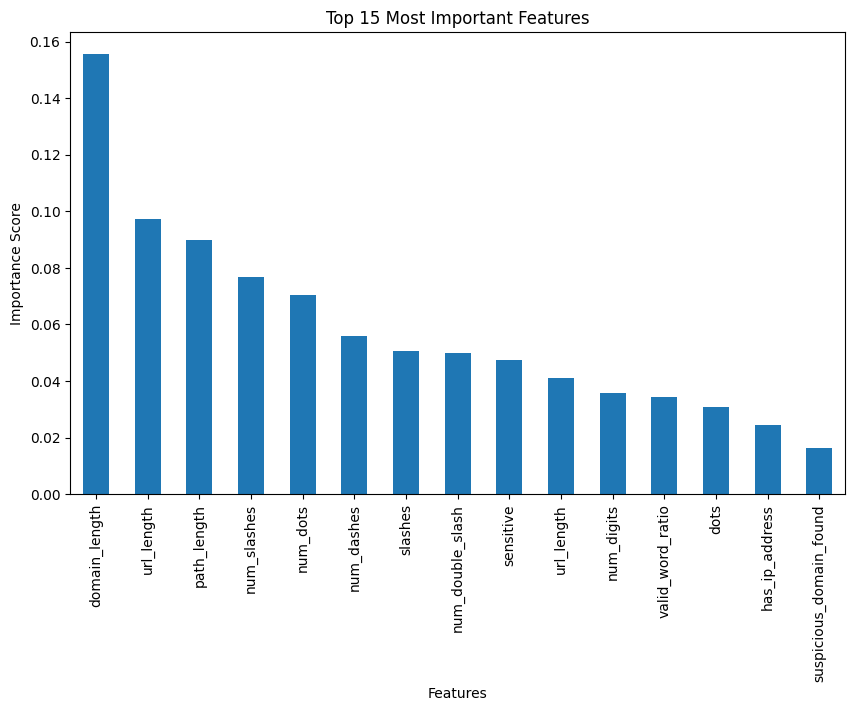

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importance from the trained model
feature_importance = pd.Series(model.feature_importances_, index=X_train.columns)

# Sort features by importance
feature_importance = feature_importance.sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(10,6))
feature_importance[:15].plot(kind='bar')
plt.title("Top 15 Most Important Features")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()


### Save Model

In [8]:
import joblib

# Save trained model
joblib.dump(model, "random_forest_model.pkl")

# Save feature columns
joblib.dump(list(df.drop(columns=['label']).columns), "feature_columns.pkl")


['feature_columns.pkl']